In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
alxmamaev_flowers_recognition_path = kagglehub.dataset_download('alxmamaev/flowers-recognition')

print('Data source import complete.')


Data source import complete.


# A `Sim`ple framework for `c`ontrastive `l`earning of visual `r`epresentation
<div style="text-align:center">
    <img src="https://1.bp.blogspot.com/--vH4PKpE9Yo/Xo4a2BYervI/AAAAAAAAFpM/vaFDwPXOyAokAC8Xh852DzOgEs22NhbXwCLcBGAsYHQ/s640/image4.gif" width="400" height="500">
</div>
<p style="text-align:center">Source: <a href="https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html">Google AI Blog</a></p>

In this kernel we will code a minimal implementation of [A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/abs/2002.05709) by Chen et. al. With the analogy of the [Le Cake](https://youtu.be/7I0Qt7GALVk?t=2773) Yann LeCun quite warmly directs us into the realms of the unsupervised learning paradigm. The goal of unsupervised learning is to utilise the vast amount of unlabelled data to formalise a representation that helps in learning in general. SimCLR provides a great platform (and an easy one too) to help achieve a good representation out of unlabelled images. The itutions and conjectures provided by the paper comes quite naturally to one's mind. The ease of the concepts will be portrayed in the kernel along with some comments on the same.

SimCLR is based out of the following simplified modules:
- A stochastic data augmentation module.
- A neural network base encoder $f(.)$.
- A neural network projection head $g(.)$
- A contrastive loss function.

> This will not be one of my reports where I investigate the ins and outs of the paper. I would likely try my hand at PyTorch and the paper both at the same time. Please feel free to fork the kernel or start a discussion in the comments about the ways I can boost the efficiency of the code.

In [2]:
# %%bash
# tree -d /kaggle/input/flowers-recognition/

> Here we see a redundant folder `floweres/flowers`. This is a probelm with the dataset. We will be using the nested flowers directory in the kernel.

# Imports
The following imports will be used in the kernel.

In [3]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [4]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 2.6.0+cu124
DEVICE: cuda


# Stochastic Augmentation Module

In this section we will talk about the data pipeline. The authors suggest that a strong data augmentation is useful for unsupervised learning.
The following augmentation are suggested by the authors:
- Random Crop with Resize
- Random Horizontal Flip with 50% probability
- Random Color Distortion
    - Random Color Jitter with 80% probability
    - Random Color Drop with 20% probability
- Random Gaussian Blur with 50% probability

<div style="text-align:center">
    <img src="https://amitness.com/images/simclr-random-transformation-function.gif" width="400" height="500">
</div>
<p style="text-align:center">Source: <a href="https://amitness.com/2020/03/illustrated-simclr/">Amitness' take on SimCLR</a></p>

The data pipeline does not take an image and output a single augmented view, but on the contrary, outputs two randomly augmented views of the original image. The reason behind two distinct views will become simpler as we proceed to the next section.


In [5]:
# 定义数据增强模块
# 数据增强包括随机裁剪、水平翻转、颜色抖动、灰度化和高斯模糊等操作。
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.

    Args:
        s: Strength parameter.

    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)

    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)

    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform

# 定义对比学习视图生成器
class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

## Prepaer the Data
In PyTorch we have two primitive classes to deal with data:
- torch.utils.data.DataSet
- torch.utils.data.DataLoader

The DataSet class helps in encapsulating the raw data. The DataLoader class helps in iterating over the DataSet that we make.

In [6]:
# 自定义数据集类
class CustomDataset(Dataset):
    """Flowers Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.list_images[idx]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [7]:
alxmamaev_flowers_recognition_path

'/kaggle/input/flowers-recognition'

In [8]:
# The size of the images
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

flowers_ds = CustomDataset(
    list_images=glob.glob("/kaggle/input/flowers-recognition/flowers/*/*.jpg"),
    transform=custom_transform
)

### Visualise the data pipeline

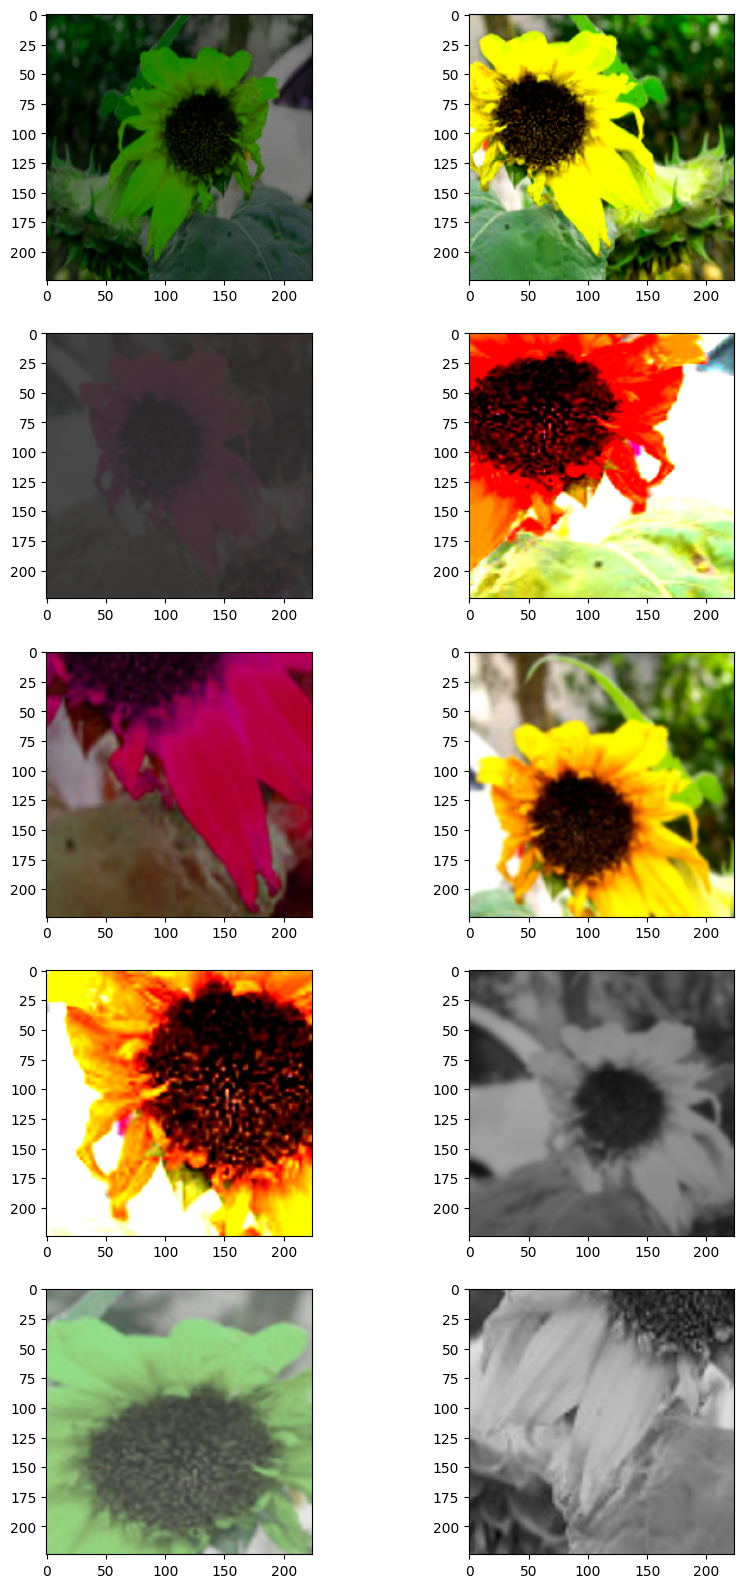

In [9]:
plt.figure(figsize=(10,20))
def view_data(flowers, index):
    for i in range(1,6):
        images = flowers[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(flowers_ds,2000)

In [10]:
BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    flowers_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

# SimCLR Model

As we remember the data pipeline gives us two augmented views of an image. The views go into a neural network encoder $f(.)$ that gives us the corresponding representation of the augmented views. Our objective is to maximise the similarity quotient of the two distinct learned representations. The idea here is to force the model to learn a general representation of an object from two distinct augmented views of it. The intuition is quite similar to viewing an object from different perspectives and gaining a better understanding.

The authors do not put constraint on the encoder model, here I have used ResNet18 as the data is quite small to use a bigger architecture. The similarity quotient comes from the representations learned by the encoder model. It was seen that projecting the encoded vector into a different latent space by an MLP helped in learning better (richer) representations. Here comes the projector $g(.)$ layer. The only objective of the projector is to project the encoder output to a richer latent space.

$$
h = f(x)\\
z = g(h)
$$

In [11]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

# 定义 SimCLR 模型
class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity() # 替换 ResNet 的全连接层
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)

        encoding = self.encoder(x) # 编码器输出
        projection = self.projection(encoding) # 投影到新的空间
        return projection

# Contrastive Loss

The loss function is basically built on top of two things:
- softmax
- cosine similarity

With the projected vectors we perform a cosine similarity function to check how similar they are. We perform the cosine similarity upon both the positive and negative pairs. After we have the similarity matrix we perform a softmax to have a probability distribution of the entire model. Our objective is to tune the knobs of the model so that this softmax distribution is peaked on the positive pair. The paper uses negative log of the softmax,  here we will approach a similar idea and use the cross entropy loss with the softmax similarity distribution. The authors have used the same approach in the [official code](https://github.com/google-research/simclr/blob/3ad6700c1b139ee18e43f73546b7263a710de699/objective.py#L82-L86) too.

In [12]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

# 定义对比损失函数
def cont_loss(features, temp):
    """
    The NTxent Loss.

    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch

    Returns:
        the NTxent loss
    """
    # 计算相似度矩阵
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    # 掩码矩阵
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    # 去掉对角线
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    # 正样本
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    # 负样本
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126
    
    # 拼接正负样本
    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp # 应用温度缩放
    return logits, labels

In [13]:
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters())

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(train_dl):
        # 获取两种视图的投影
        projections = simclr_model([view.to(DEVICE) for view in views])
        # 计算对比损失
        logits, labels = cont_loss(projections, temp=2)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 10 LOSS: 0.6953 
EPOCH: 1 BATCH: 20 LOSS: 0.5498 
EPOCH: 1 BATCH: 30 LOSS: 0.5455 
Time taken: 3.914 mins
EPOCH: 2 BATCH: 10 LOSS: 0.5446 
EPOCH: 2 BATCH: 20 LOSS: 0.5433 
EPOCH: 2 BATCH: 30 LOSS: 0.5406 
Time taken: 3.755 mins
EPOCH: 3 BATCH: 10 LOSS: 0.5392 
EPOCH: 3 BATCH: 20 LOSS: 0.5349 
EPOCH: 3 BATCH: 30 LOSS: 0.5385 
Time taken: 3.712 mins
EPOCH: 4 BATCH: 10 LOSS: 0.5345 
EPOCH: 4 BATCH: 20 LOSS: 0.5329 
EPOCH: 4 BATCH: 30 LOSS: 0.5303 
Time taken: 3.680 mins
EPOCH: 5 BATCH: 10 LOSS: 0.5299 
EPOCH: 5 BATCH: 20 LOSS: 0.5269 
EPOCH: 5 BATCH: 30 LOSS: 0.5283 
Time taken: 3.587 mins
EPOCH: 6 BATCH: 10 LOSS: 0.5241 
EPOCH: 6 BATCH: 20 LOSS: 0.5208 
EPOCH: 6 BATCH: 30 LOSS: 0.5214 
Time taken: 3.679 mins
EPOCH: 7 BATCH: 10 LOSS: 0.5168 
EPOCH: 7 BATCH: 20 LOSS: 0.5154 
EPOCH: 7 BATCH: 30 LOSS: 0.5147 
Time taken: 3.695 mins
EPOCH: 8 BATCH: 10 LOSS: 0.5041 
EPOCH: 8 BATCH: 20 LOSS: 0.5075 
EPOCH: 8 BATCH: 30 LOSS: 0.5076 
Time taken: 3.638 mins
EPOCH: 9 BATCH: 10 LOSS:

# Down Stream Task

After we have a trained SimCLR model we will discard the projection head and use the encoder only. We provide a `Centre Cropped` image to the encoder and get a learned representation of the images. This representation is then used in down stream tasks like classification.

Here we train the representations to predict the classification task provided with the flowers dataset.

In [15]:
from torchvision.transforms import (
    CenterCrop,
    Resize
)

In [17]:
resize = Resize(255)
ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([
    resize,
    ccrop,
    ttensor,
])

flowers_ds = ImageFolder(
    root="/kaggle/input/flowers-recognition/flowers/",
    transform=custom_transform
)

nu_classes = len(flowers_ds.classes)

BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    flowers_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [18]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        simclr = model
        simclr.linear_eval = True
        simclr.projection = Identity()
        self.simclr = simclr
        for param in self.simclr.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(512, nu_classes)
    def forward(self, x):
        encoding = self.simclr(x)
        pred = self.linear(encoding)
        return pred

In [19]:
eval_model = LinearEvaluation(simclr_model, nu_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(eval_model.parameters())

In [20]:
EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, element in enumerate(train_dl):
        image, label = element
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = eval_model(image)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 10 LOSS: 0.1608 
EPOCH: 1 BATCH: 20 LOSS: 0.1446 
EPOCH: 1 BATCH: 30 LOSS: 0.1391 
Time taken: 0.284 mins
EPOCH: 2 BATCH: 10 LOSS: 0.1346 
EPOCH: 2 BATCH: 20 LOSS: 0.1315 
EPOCH: 2 BATCH: 30 LOSS: 0.1270 
Time taken: 0.298 mins
EPOCH: 3 BATCH: 10 LOSS: 0.1257 
EPOCH: 3 BATCH: 20 LOSS: 0.1245 
EPOCH: 3 BATCH: 30 LOSS: 0.1225 
Time taken: 0.318 mins
EPOCH: 4 BATCH: 10 LOSS: 0.1195 
EPOCH: 4 BATCH: 20 LOSS: 0.1228 
EPOCH: 4 BATCH: 30 LOSS: 0.1244 
Time taken: 0.274 mins
EPOCH: 5 BATCH: 10 LOSS: 0.1185 
EPOCH: 5 BATCH: 20 LOSS: 0.1241 
EPOCH: 5 BATCH: 30 LOSS: 0.1207 
Time taken: 0.275 mins
EPOCH: 6 BATCH: 10 LOSS: 0.1182 
EPOCH: 6 BATCH: 20 LOSS: 0.1190 
EPOCH: 6 BATCH: 30 LOSS: 0.1204 
Time taken: 0.274 mins
EPOCH: 7 BATCH: 10 LOSS: 0.1164 
EPOCH: 7 BATCH: 20 LOSS: 0.1210 
EPOCH: 7 BATCH: 30 LOSS: 0.1181 
Time taken: 0.266 mins
EPOCH: 8 BATCH: 10 LOSS: 0.1163 
EPOCH: 8 BATCH: 20 LOSS: 0.1177 
EPOCH: 8 BATCH: 30 LOSS: 0.1154 
Time taken: 0.264 mins
EPOCH: 9 BATCH: 10 LOSS:

# Visualize Distribution
The following t-SNE visualizations compare raw image data and features extracted by a SimCLR encoder. These plots demonstrate how contrastive learning encourages the model to structure the feature space more meaningfully, even without supervision.

In [23]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np


raw_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


# use ImageFolder to create dataset
flowers_ds = ImageFolder(
    root="/kaggle/input/flowers-recognition/flowers/",
    transform=raw_transform
)

# 显示类别映射（如：{'daisy': 0, 'rose': 1, ...}）
print("类别映射:", flowers_ds.class_to_idx)


# choose 30% of the dataset
total_len = len(flowers_ds)
subset_len = int(0.3 * total_len)

np.random.seed(42)
subset_indices = np.random.choice(total_len, subset_len, replace=False)

subset_ds = Subset(flowers_ds, subset_indices)
subset_loader = DataLoader(subset_ds, batch_size=64, shuffle=False)


类别映射: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 定义一个函数，用于可视化特征的 t-SNE 分布
def visualize_with_labels(model, dataloader, device, title="Feature TSNE"):
    """
    使用 t-SNE 可视化模型提取的特征分布。

    Args:
        model: 训练好的模型，用于提取特征。
        dataloader: 数据加载器，提供输入数据。
        device: 设备（CPU 或 GPU）。
        title: 图表标题。
    """
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feats = model(imgs)
            if isinstance(feats, tuple):  # 兼容 projection head
                feats = feats[0]
            features.append(feats.cpu())
            labels.append(lbls)
    
    # 将所有批次的特征和标签拼接成单个张量
    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    # 使用 t-SNE 将高维特征降维到 2D
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_result = tsne.fit_transform(features)
    
    # 绘制 t-SNE 可视化图
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="tab10", s=40)
    plt.title(title)
    plt.legend(loc="best", title="Class ID")
    plt.show()

# 定义一个函数，用于可视化原始像素的 t-SNE 分布
def visualize_raw_pixels(dataloader, device, title="Raw Pixel TSNE"):
    """
    使用 t-SNE 可视化原始像素分布。

    Args:
        dataloader: 数据加载器，提供输入数据。
        device: 设备（CPU 或 GPU）。
        title: 图表标题。
    """
    features = []
    labels = []

    for imgs, lbls in dataloader:
        imgs = imgs.to(device)
        features.append(imgs.view(imgs.size(0), -1).cpu())
        labels.append(lbls)

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # 使用 t-SNE 将高维像素数据降维到 2D
    tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(features)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="tab10", s=40)
    plt.title(title)
    plt.legend(loc="best", title="Class ID")
    plt.show()


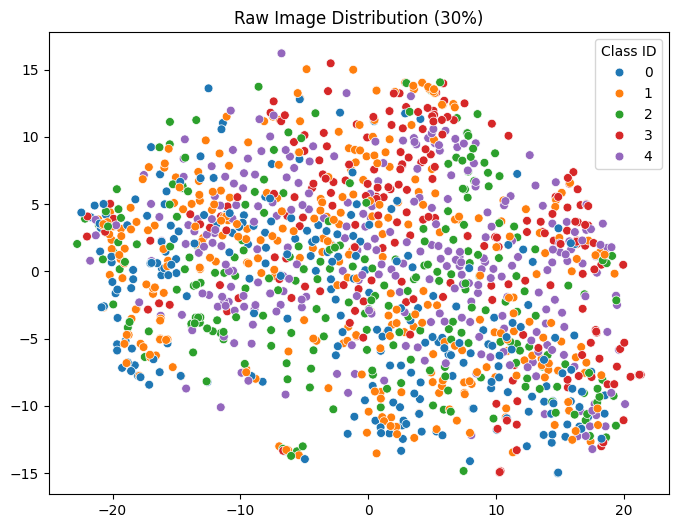

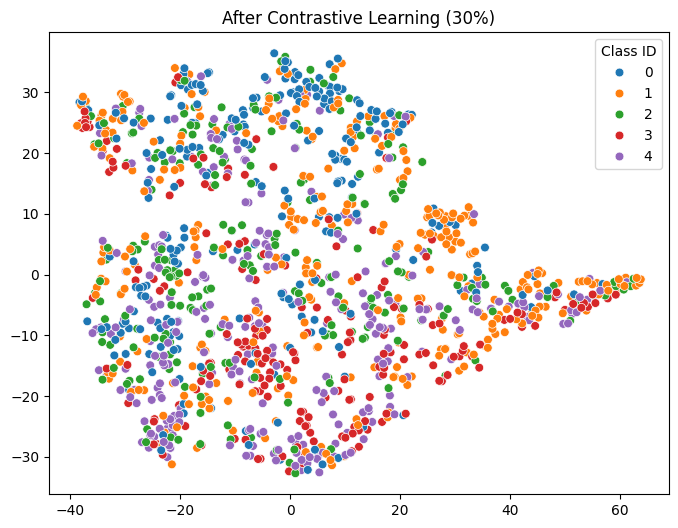

In [25]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 可视化原始像素的 t-SNE 分布
visualize_raw_pixels(subset_loader, DEVICE, title="Raw Image Distribution (30%)")

# 可视化经过对比学习后的特征分布
visualize_with_labels(simclr_model, subset_loader, DEVICE, title="After Contrastive Learning (30%)")


# Ending note

I have taken help from the following places, I am sure it will help the keen reader.
- [SimCLR](https://arxiv.org/abs/2002.05709)
- [Official SimCLR repository](https://github.com/google-research/simclr)
- [Amit Chaudhary's blog on SimCLR](https://amitness.com/2020/03/illustrated-simclr/)
- [Sayak Paul's blog on SimCLR](https://wandb.ai/sayakpaul/simclr/reports/Towards-Self-Supervised-Image-Understanding-with-SimCLR--VmlldzoxMDI5NDM)
- [@sthalles' SimCLR implementation in PyTorch](https://github.com/sthalles/SimCLR)

I have tried producing a minimal implementation of SimCLR with PyTorch here. This was my first time with PyTorch, feedbacks are always welcome.